# Part 2: Valuation-Based Dynamic DCA: MVRV & NVT Analysis

**Part 1** (time_of_purchase_dca) showed that *when* you buy (weekday, month, frequency) has negligible impact on accumulation efficiency. This notebook explores whether *how much* you buy, scaled by on-chain valuation signals, can do better.

**Approach:**
1. EDA of MVRV (Market Value / Realised Value) and NVT (Network Value / Transaction Volume) across BTC history
2. Define valuation market states (undervalued / neutral / overvalued)
3. Build dynamic DCA rules that scale buy amounts based on these market states
4. Backtest dynamic DCA vs uniform DCA across all rolling 12-month windows
5. Evaluate whether valuation-based sizing improves accumulation efficiency

**Key constraint:** total budget per 12-month window is held **equal** between strategies (dynamic DCA only reshuffles *when* the budget is deployed it doesn't spend more overall).

## 1. Setup and Configuration

In [65]:
from __future__ import annotations

from datetime import date
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import polars as pl
import seaborn as sns
from scipy import stats

# --- Plot style ---
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# --- Paths ---
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "eda" else NOTEBOOK_DIR
DATA_DIR = PROJECT_ROOT / "data"
COINMETRICS_PATH = DATA_DIR / "Coin Metrics" / "coinmetrics_btc.csv"
PLOTS_DIR = PROJECT_ROOT / "eda" / "plots"
PLOTS_DIR.mkdir(exist_ok=True, parents=True)

# --- DCA budget (same as Part 1 for comparability) ---
BASE_BUY_USD = 10.0  # baseline daily buy amount

print(f"Data file : {COINMETRICS_PATH}")
print(f"Plots dir : {PLOTS_DIR}")

Data file : c:\Users\tsivakumar\Projects\OMSA\data\Coin Metrics\coinmetrics_btc.csv
Plots dir : c:\Users\tsivakumar\Projects\OMSA\eda\plots


## 2. Load & Prepare Data

Load Coin Metrics CSV, parse dates, select price + on-chain valuation columns, and compute:
- **NVT proxy** = `CapMrktCurUSD / volume_reported_spot_usd_1d` (since `NVTAdj` is not in this dataset)
- Forward returns (7d, 30d, 90d) to test if MVRV/NVT predict future price moves

In [66]:
cols_needed = [
    "time", "PriceUSD", "CapMVRVCur", "CapMrktCurUSD",
    "volume_reported_spot_usd_1d", "TxCnt", "TxTfrCnt",
    "FlowInExUSD", "FlowOutExUSD", "HashRate",
]

raw = (
    pl.scan_csv(str(COINMETRICS_PATH), infer_schema_length=10000)
    .with_columns(pl.col("time").str.strptime(pl.Date, "%Y-%m-%d").alias("date"))
    .select(["date"] + [c for c in cols_needed if c != "time"])
    .filter(pl.col("PriceUSD").is_not_null() & pl.col("CapMVRVCur").is_not_null())
    .sort("date")
    .collect()
)

# Compute NVT proxy and forward returns
btc = raw.with_columns([
    # NVT proxy: market cap / daily spot volume (smoothed with 14-day MA to reduce noise)
    (pl.col("CapMrktCurUSD") / pl.col("volume_reported_spot_usd_1d")).alias("NVT_raw"),
    (pl.col("CapMrktCurUSD") / pl.col("volume_reported_spot_usd_1d").rolling_mean(14)).alias("NVT_14d"),
    # MVRV 30-day moving average for smoother signal
    pl.col("CapMVRVCur").rolling_mean(30).alias("MVRV_30d"),
    # Forward returns
    (pl.col("PriceUSD").shift(-7) / pl.col("PriceUSD") - 1).alias("fwd_ret_7d"),
    (pl.col("PriceUSD").shift(-30) / pl.col("PriceUSD") - 1).alias("fwd_ret_30d"),
    (pl.col("PriceUSD").shift(-90) / pl.col("PriceUSD") - 1).alias("fwd_ret_90d"),
    # Rolling percentiles for MVRV (2-year lookback)
    pl.col("CapMVRVCur").rolling_quantile(0.5, window_size=730).alias("MVRV_median_2yr"),
])

# Add rolling MVRV z-score (2-year lookback)
btc = btc.with_columns([
    ((pl.col("CapMVRVCur") - pl.col("CapMVRVCur").rolling_mean(730))
     / pl.col("CapMVRVCur").rolling_std(730)).alias("MVRV_zscore"),
    ((pl.col("NVT_14d") - pl.col("NVT_14d").rolling_mean(730))
     / pl.col("NVT_14d").rolling_std(730)).alias("NVT_zscore"),
])

print(f"Loaded {len(btc):,} rows  |  {btc['date'].min()} to {btc['date'].max()}")
print(f"Columns: {btc.columns}")
btc.select(["date", "PriceUSD", "CapMVRVCur", "MVRV_30d", "NVT_raw", "NVT_14d", "MVRV_zscore", "NVT_zscore"]).head(5)

Loaded 5,659 rows  |  2010-07-18 to 2026-01-13
Columns: ['date', 'PriceUSD', 'CapMVRVCur', 'CapMrktCurUSD', 'volume_reported_spot_usd_1d', 'TxCnt', 'TxTfrCnt', 'FlowInExUSD', 'FlowOutExUSD', 'HashRate', 'NVT_raw', 'NVT_14d', 'MVRV_30d', 'fwd_ret_7d', 'fwd_ret_30d', 'fwd_ret_90d', 'MVRV_median_2yr', 'MVRV_zscore', 'NVT_zscore']


date,PriceUSD,CapMVRVCur,MVRV_30d,NVT_raw,NVT_14d,MVRV_zscore,NVT_zscore
date,f64,f64,f64,f64,f64,f64,f64
2010-07-18,0.08584,146.038332,null,58122.445978,null,null,null
2010-07-19,0.0808,62.56513,null,5623.799619,null,null,null
2010-07-20,0.074736,45.10663,null,12579.234727,null,null,null
2010-07-21,0.079193,38.35756,null,6513.301988,null,null,null
2010-07-22,0.05847,25.132348,null,1569.909499,null,null,null


## 3. MVRV Exploratory Analysis

**MVRV (Market Value to Realised Value)** compares BTC's market cap to its realised cap (the aggregate cost basis of all coins). Key intuition:
- **MVRV < 1** → market is trading below aggregate cost basis (historically rare, strong buy signal)
- **MVRV 1–2** → fair value zone
- **MVRV > 3** → market significantly above cost basis (overheated)

We explore: distribution, time series, and relationship to forward returns.

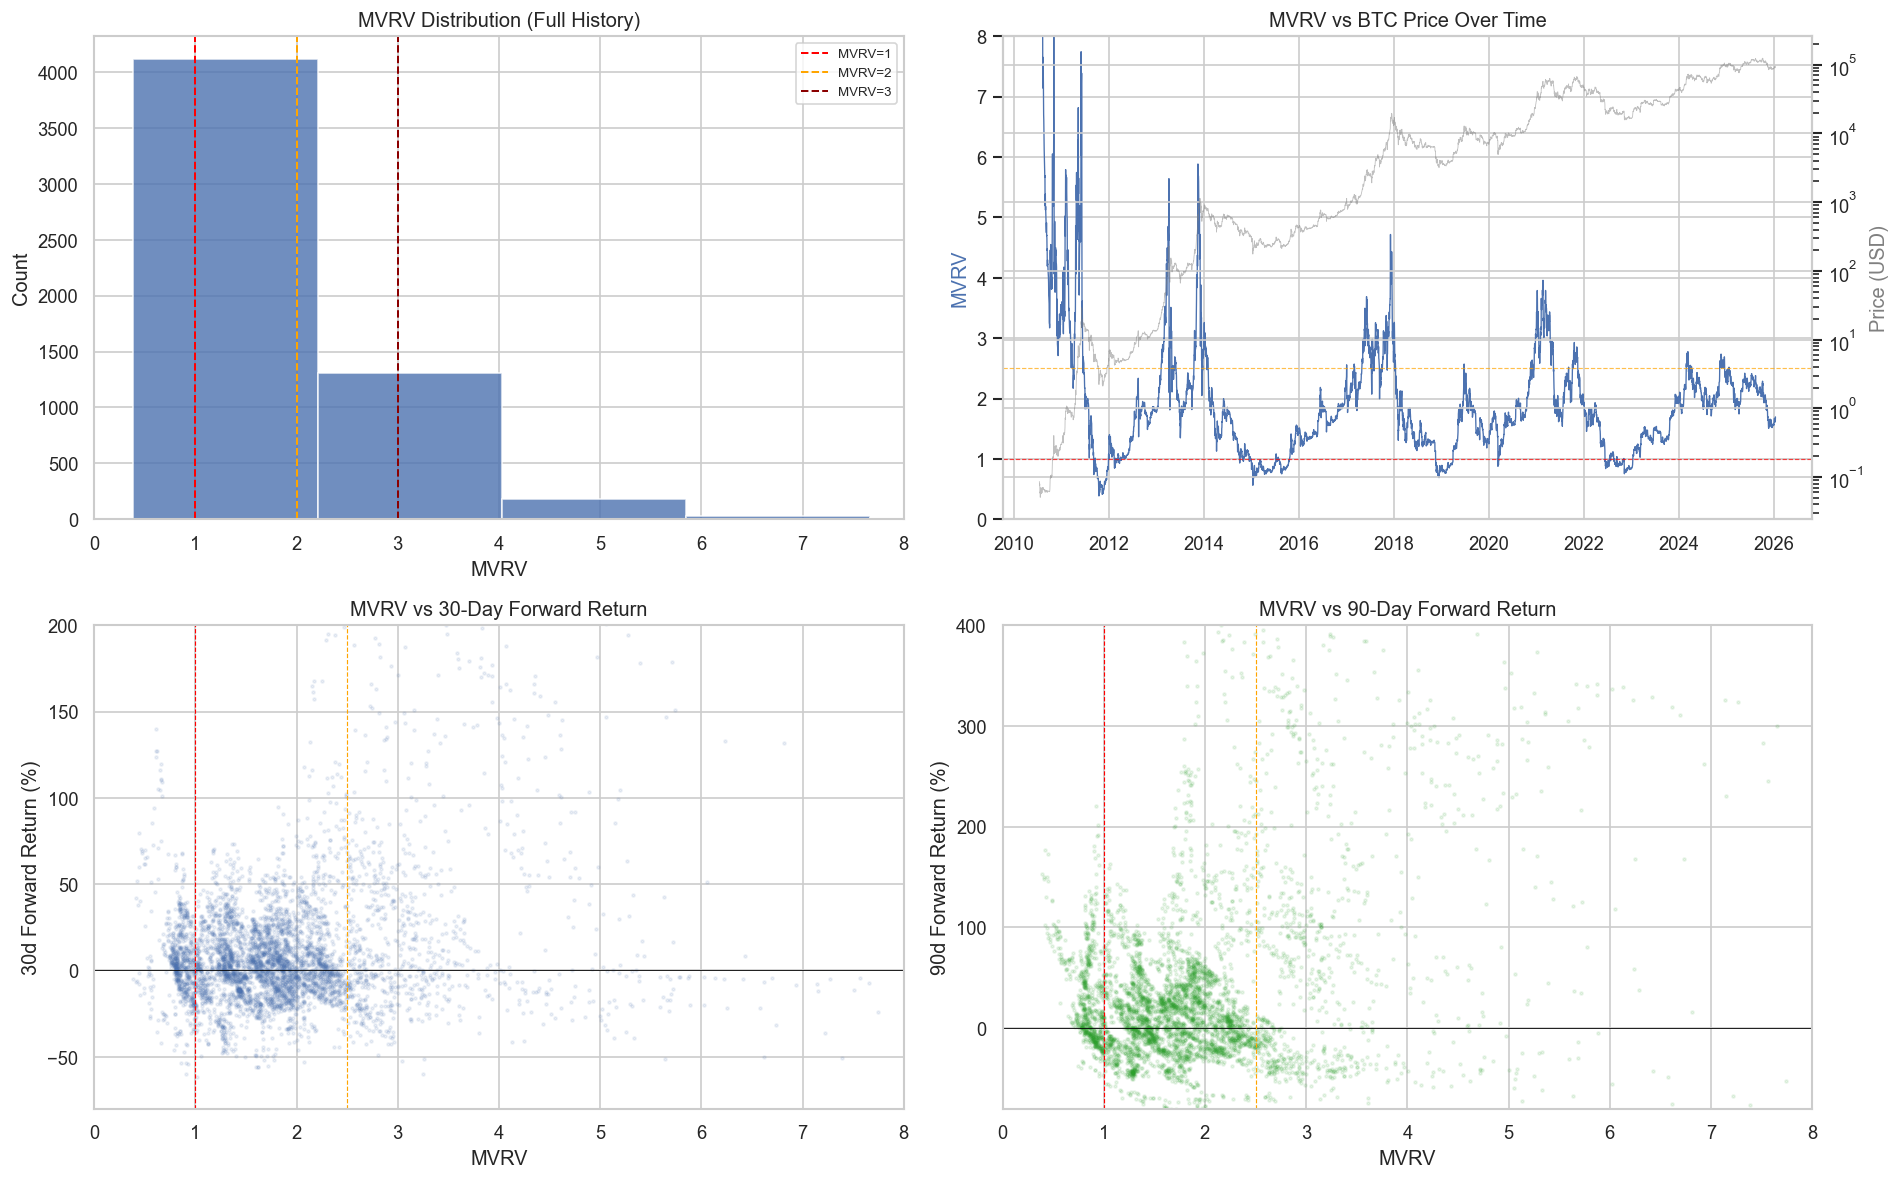

Saved mvrv_eda.png


In [67]:
# --- MVRV distribution and time series ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# (A) MVRV histogram
ax = axes[0, 0]
mvrv_vals = btc["CapMVRVCur"].drop_nulls().to_numpy()
ax.hist(mvrv_vals, bins=80, color="#4c72b0", edgecolor="white", alpha=0.8)
for thresh, color, label in [(1.0, "red", "MVRV=1"), (2.0, "orange", "MVRV=2"), (3.0, "darkred", "MVRV=3")]:
    ax.axvline(thresh, color=color, linestyle="--", linewidth=1.2, label=label)
ax.set_title("MVRV Distribution (Full History)")
ax.set_xlabel("MVRV")
ax.set_ylabel("Count")
ax.legend(fontsize=8)
ax.set_xlim(0, min(8, mvrv_vals.max()))

# (B) MVRV over time with price overlay
ax = axes[0, 1]
pdf = btc.select(["date", "PriceUSD", "CapMVRVCur"]).to_pandas()
ax2 = ax.twinx()
ax.plot(pdf["date"], pdf["CapMVRVCur"], color="#4c72b0", linewidth=0.8, label="MVRV")
ax.axhline(1.0, color="red", linestyle="--", linewidth=0.7, alpha=0.7)
ax.axhline(2.5, color="orange", linestyle="--", linewidth=0.7, alpha=0.7)
ax2.plot(pdf["date"], pdf["PriceUSD"], color="gray", linewidth=0.5, alpha=0.5, label="Price")
ax.set_title("MVRV vs BTC Price Over Time")
ax.set_ylabel("MVRV", color="#4c72b0")
ax2.set_ylabel("Price (USD)", color="gray")
ax2.set_yscale("log")
ax.set_ylim(0, 8)

# (C) MVRV vs 30-day forward return (scatter)
ax = axes[1, 0]
scatter_df = btc.filter(pl.col("fwd_ret_30d").is_not_null()).select(["CapMVRVCur", "fwd_ret_30d"]).to_pandas()
ax.scatter(scatter_df["CapMVRVCur"], scatter_df["fwd_ret_30d"] * 100, alpha=0.1, s=3, color="#4c72b0")
ax.axhline(0, color="black", linewidth=0.5)
ax.axvline(1.0, color="red", linestyle="--", linewidth=0.7)
ax.axvline(2.5, color="orange", linestyle="--", linewidth=0.7)
ax.set_title("MVRV vs 30-Day Forward Return")
ax.set_xlabel("MVRV")
ax.set_ylabel("30d Forward Return (%)")
ax.set_xlim(0, 8)
ax.set_ylim(-80, 200)

# (D) MVRV vs 90-day forward return (scatter)
ax = axes[1, 1]
scatter_df90 = btc.filter(pl.col("fwd_ret_90d").is_not_null()).select(["CapMVRVCur", "fwd_ret_90d"]).to_pandas()
ax.scatter(scatter_df90["CapMVRVCur"], scatter_df90["fwd_ret_90d"] * 100, alpha=0.1, s=3, color="#2ca02c")
ax.axhline(0, color="black", linewidth=0.5)
ax.axvline(1.0, color="red", linestyle="--", linewidth=0.7)
ax.axvline(2.5, color="orange", linestyle="--", linewidth=0.7)
ax.set_title("MVRV vs 90-Day Forward Return")
ax.set_xlabel("MVRV")
ax.set_ylabel("90d Forward Return (%)")
ax.set_xlim(0, 8)
ax.set_ylim(-80, 400)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "mvrv_eda.png", bbox_inches="tight")
plt.show()
print("Saved mvrv_eda.png")

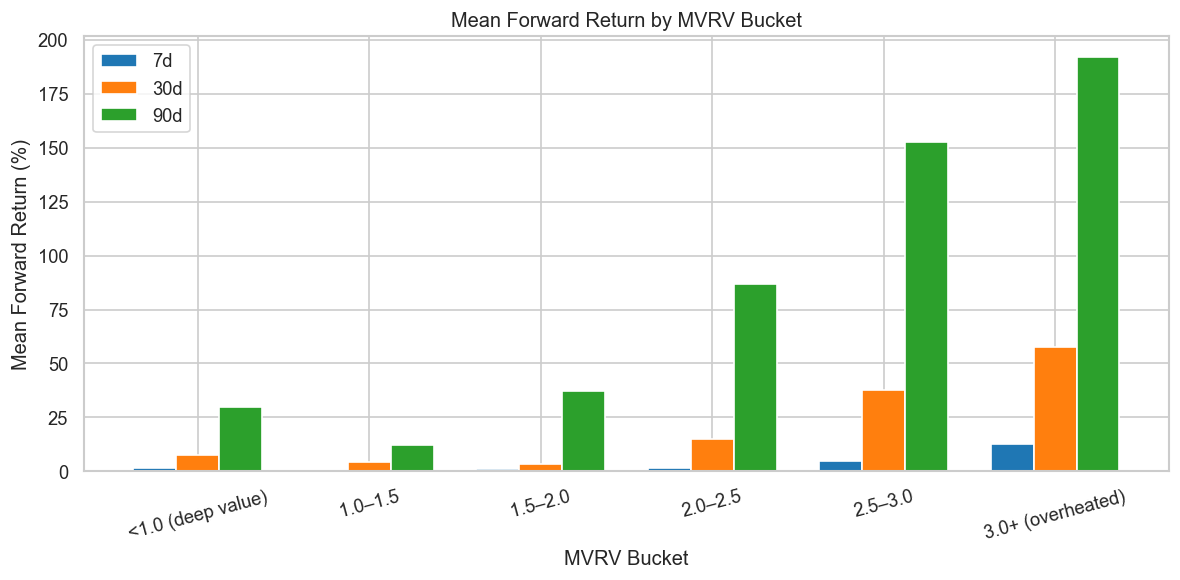

MVRV Bucket Statistics:


mvrv_bucket,mean_fwd_7d,mean_fwd_30d,mean_fwd_90d,median_fwd_30d,std_fwd_30d,n_days
str,f64,f64,f64,f64,f64,u32
"""1.0–1.5""",0.008486,0.042178,0.122033,0.02096,0.218746,1282
"""1.5–2.0""",0.009996,0.036603,0.373825,0.027949,0.202272,1579
"""2.0–2.5""",0.015548,0.152571,0.868032,0.020896,0.536499,956
"""2.5–3.0""",0.047104,0.376536,1.526468,0.073085,0.975025,447
"""3.0+ (overheated)""",0.125933,0.576489,1.919835,0.150996,1.082729,590
"""<1.0 (deep value)""",0.015659,0.074592,0.299158,0.040434,0.253809,775


In [68]:
# --- MVRV quintile analysis: mean forward returns by MVRV bucket ---
mvrv_fwd = btc.filter(
    pl.col("CapMVRVCur").is_not_null() & pl.col("fwd_ret_30d").is_not_null()
)

# Define MVRV buckets
mvrv_fwd = mvrv_fwd.with_columns(
    pl.when(pl.col("CapMVRVCur") < 1.0).then(pl.lit("<1.0 (deep value)"))
    .when(pl.col("CapMVRVCur") < 1.5).then(pl.lit("1.0–1.5"))
    .when(pl.col("CapMVRVCur") < 2.0).then(pl.lit("1.5–2.0"))
    .when(pl.col("CapMVRVCur") < 2.5).then(pl.lit("2.0–2.5"))
    .when(pl.col("CapMVRVCur") < 3.0).then(pl.lit("2.5–3.0"))
    .otherwise(pl.lit("3.0+ (overheated)"))
    .alias("mvrv_bucket")
)

bucket_order = ["<1.0 (deep value)", "1.0–1.5", "1.5–2.0", "2.0–2.5", "2.5–3.0", "3.0+ (overheated)"]

bucket_stats = (
    mvrv_fwd
    .group_by("mvrv_bucket")
    .agg([
        pl.col("fwd_ret_7d").mean().alias("mean_fwd_7d"),
        pl.col("fwd_ret_30d").mean().alias("mean_fwd_30d"),
        pl.col("fwd_ret_90d").mean().alias("mean_fwd_90d"),
        pl.col("fwd_ret_30d").median().alias("median_fwd_30d"),
        pl.col("fwd_ret_30d").std().alias("std_fwd_30d"),
        pl.len().alias("n_days"),
    ])
    .sort("mvrv_bucket")
)

# Reorder
bucket_pdf = bucket_stats.to_pandas()
bucket_pdf["mvrv_bucket"] = bucket_pdf["mvrv_bucket"].astype("category")
bucket_pdf["mvrv_bucket"] = bucket_pdf["mvrv_bucket"].cat.set_categories(bucket_order)
bucket_pdf = bucket_pdf.sort_values("mvrv_bucket")

fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(bucket_pdf))
width = 0.25
ax.bar([i - width for i in x], bucket_pdf["mean_fwd_7d"] * 100, width, label="7d", color="#1f77b4")
ax.bar(x, bucket_pdf["mean_fwd_30d"] * 100, width, label="30d", color="#ff7f0e")
ax.bar([i + width for i in x], bucket_pdf["mean_fwd_90d"] * 100, width, label="90d", color="#2ca02c")
ax.set_xticks(x)
ax.set_xticklabels(bucket_pdf["mvrv_bucket"], rotation=15)
ax.axhline(0, color="black", linewidth=0.5)
ax.set_title("Mean Forward Return by MVRV Bucket")
ax.set_ylabel("Mean Forward Return (%)")
ax.set_xlabel("MVRV Bucket")
ax.legend()
plt.tight_layout()
plt.savefig(PLOTS_DIR / "mvrv_bucket_returns.png", bbox_inches="tight")
plt.show()

print("MVRV Bucket Statistics:")
bucket_stats

## 4. NVT Proxy Exploratory Analysis

**NVT (Network Value to Transaction Volume)** is like a P/E ratio for on-chain activity.
- **Low NVT** → price is supported by high transaction throughput (value)
- **High NVT** → price may be stretched relative to actual network usage

We compute NVT as `CapMrktCurUSD / volume_reported_spot_usd_1d` and use a 14-day smoothed version (`NVT_14d`) to reduce daily noise.

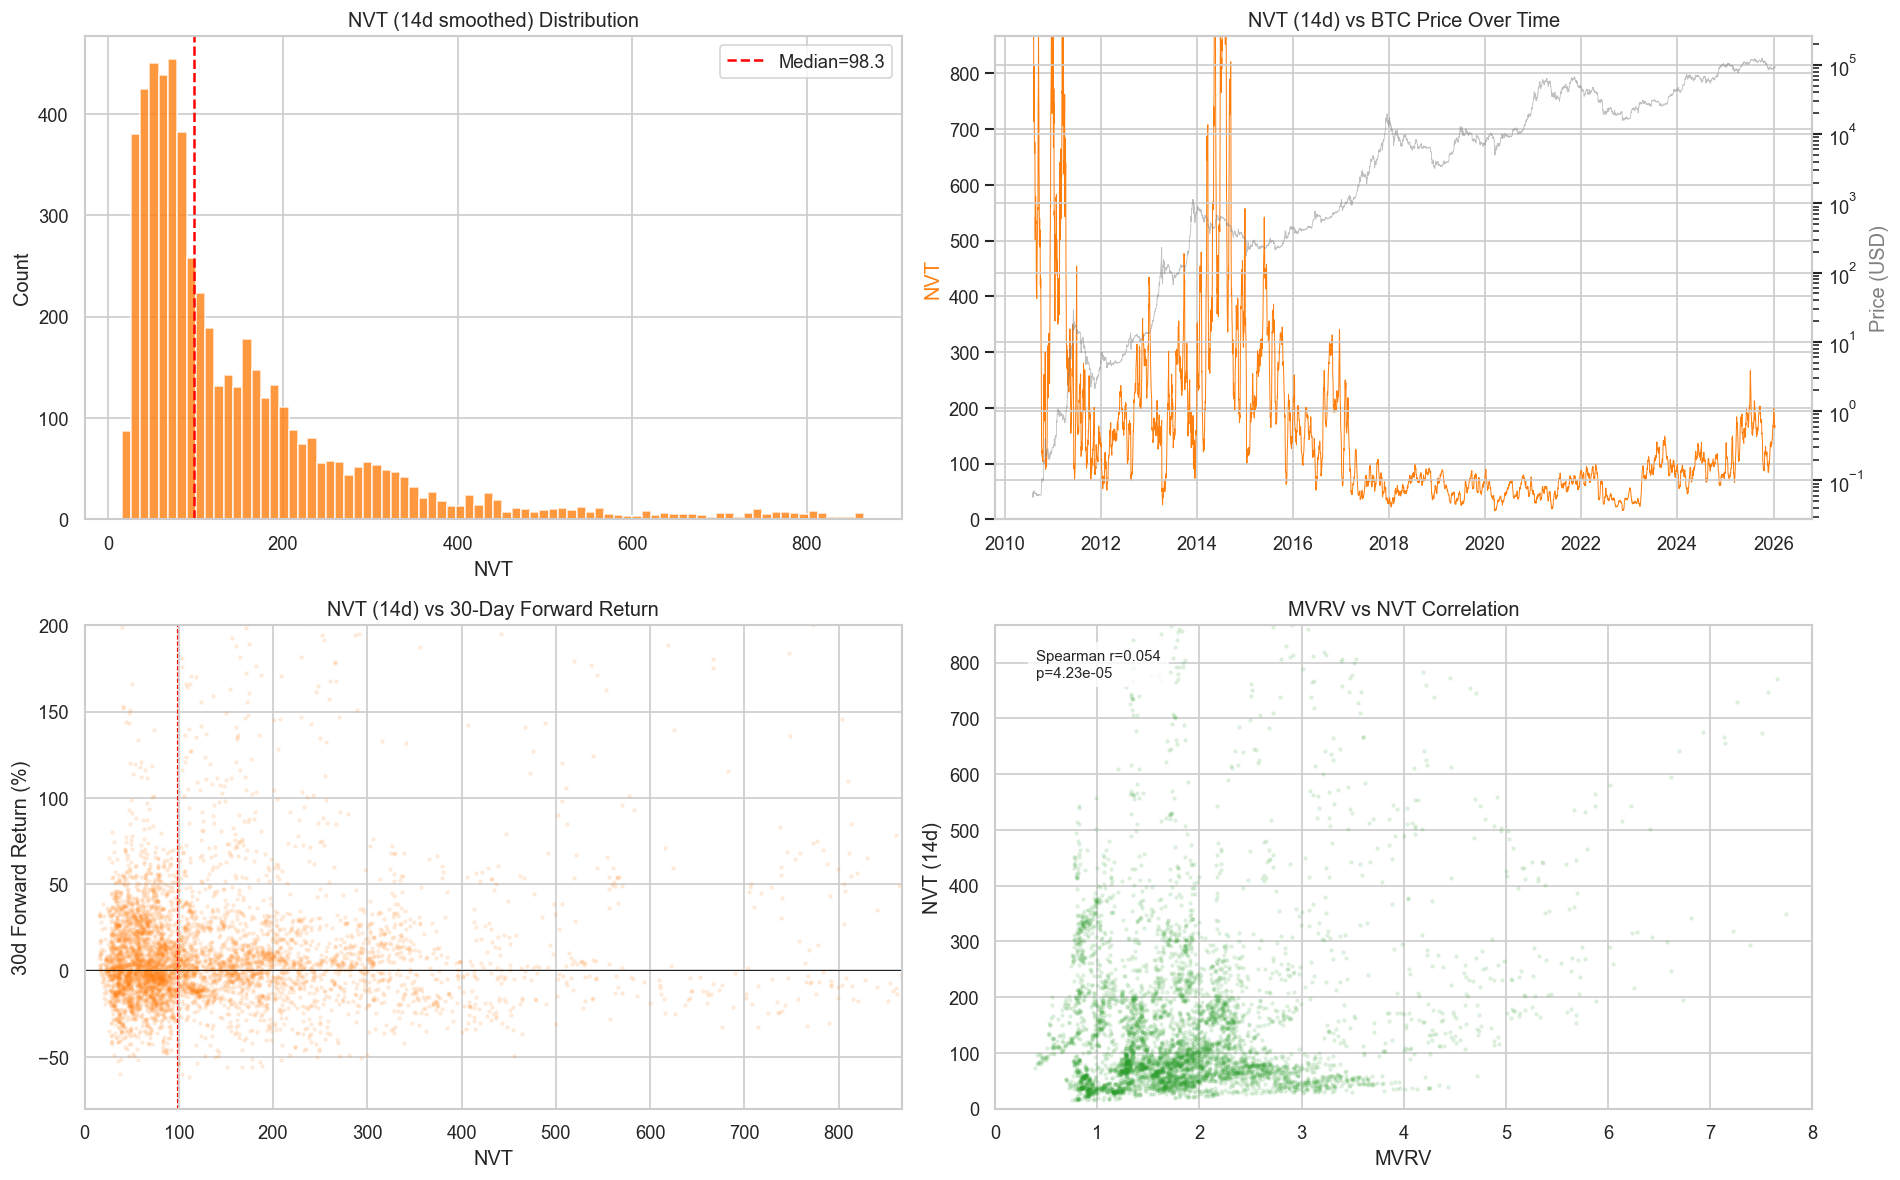

Saved nvt_eda.png


statistic,NVT_14d
str,f64
"""count""",5646.0
"""null_count""",0.0
"""mean""",158.732215
"""std""",167.461815
"""min""",15.429556
"""25%""",59.77897
"""50%""",98.313079
"""75%""",193.882365
"""max""",1714.157257


In [69]:
# --- NVT distribution and relationship to forward returns ---
nvt_df = btc.filter(pl.col("NVT_14d").is_not_null() & pl.col("NVT_14d").is_finite())

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# (A) NVT_14d histogram
ax = axes[0, 0]
nvt_vals = nvt_df["NVT_14d"].drop_nulls().to_numpy()
# Clip extreme outliers for visualization
nvt_clipped = nvt_vals[nvt_vals < np.percentile(nvt_vals, 99)]
ax.hist(nvt_clipped, bins=80, color="#ff7f0e", edgecolor="white", alpha=0.8)
ax.set_title("NVT (14d smoothed) Distribution")
ax.set_xlabel("NVT")
ax.set_ylabel("Count")
median_nvt = np.median(nvt_vals)
ax.axvline(median_nvt, color="red", linestyle="--", label=f"Median={median_nvt:.1f}")
ax.legend()

# (B) NVT over time with price
ax = axes[0, 1]
nvt_pdf = nvt_df.select(["date", "PriceUSD", "NVT_14d"]).to_pandas()
ax2 = ax.twinx()
ax.plot(nvt_pdf["date"], nvt_pdf["NVT_14d"], color="#ff7f0e", linewidth=0.6, label="NVT (14d)")
ax2.plot(nvt_pdf["date"], nvt_pdf["PriceUSD"], color="gray", linewidth=0.5, alpha=0.5)
ax.set_title("NVT (14d) vs BTC Price Over Time")
ax.set_ylabel("NVT", color="#ff7f0e")
ax2.set_ylabel("Price (USD)", color="gray")
ax2.set_yscale("log")
ax.set_ylim(0, np.percentile(nvt_vals, 99))

# (C) NVT vs 30-day forward return
ax = axes[1, 0]
nvt_scatter = nvt_df.filter(pl.col("fwd_ret_30d").is_not_null()).select(["NVT_14d", "fwd_ret_30d"]).to_pandas()
ax.scatter(nvt_scatter["NVT_14d"], nvt_scatter["fwd_ret_30d"] * 100, alpha=0.1, s=3, color="#ff7f0e")
ax.axhline(0, color="black", linewidth=0.5)
ax.axvline(median_nvt, color="red", linestyle="--", linewidth=0.7)
ax.set_title("NVT (14d) vs 30-Day Forward Return")
ax.set_xlabel("NVT")
ax.set_ylabel("30d Forward Return (%)")
ax.set_xlim(0, np.percentile(nvt_vals, 99))
ax.set_ylim(-80, 200)

# (D) MVRV-NVT correlation scatter
ax = axes[1, 1]
corr_df = btc.filter(
    pl.col("CapMVRVCur").is_not_null() & pl.col("NVT_14d").is_not_null() & pl.col("NVT_14d").is_finite()
).select(["CapMVRVCur", "NVT_14d"]).to_pandas()
ax.scatter(corr_df["CapMVRVCur"], corr_df["NVT_14d"], alpha=0.1, s=3, color="#2ca02c")
ax.set_title("MVRV vs NVT Correlation")
ax.set_xlabel("MVRV")
ax.set_ylabel("NVT (14d)")
ax.set_xlim(0, 8)
ax.set_ylim(0, np.percentile(nvt_vals, 99))
r, p = stats.spearmanr(corr_df["CapMVRVCur"], corr_df["NVT_14d"])
ax.text(0.05, 0.95, f"Spearman r={r:.3f}\np={p:.2e}", transform=ax.transAxes,
        fontsize=9, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.8))

plt.tight_layout()
plt.savefig(PLOTS_DIR / "nvt_eda.png", bbox_inches="tight")
plt.show()
print("Saved nvt_eda.png")

# NVT descriptive stats
nvt_df.select(["NVT_14d"]).describe()

## 5. Define Valuation market states

Combine MVRV and NVT z-scores into a **composite valuation signal** and classify each day into one of three market states:

| market state | Condition | Buy Multiplier |
|--------|-----------|----------------|
| **Undervalued** | Composite signal < −0.5 | 1.5× |
| **Neutral** | −0.5 ≤ signal ≤ 0.5 | 1.0× |
| **Overvalued** | Signal > 0.5 | 0.5× |

The composite signal is the average of MVRV z-score and NVT z-score (both relative to a 2-year rolling window). Using z-scores makes market state thresholds adaptive to the current cycle.

Marketstate Distribution:
shape: (3, 2)
┌─────────────┬──────┐
│ marketstate ┆ n    │
│ ---         ┆ ---  │
│ str         ┆ u32  │
╞═════════════╪══════╡
│ neutral     ┆ 2452 │
│ overvalued  ┆ 1864 │
│ undervalued ┆ 1343 │
└─────────────┴──────┘


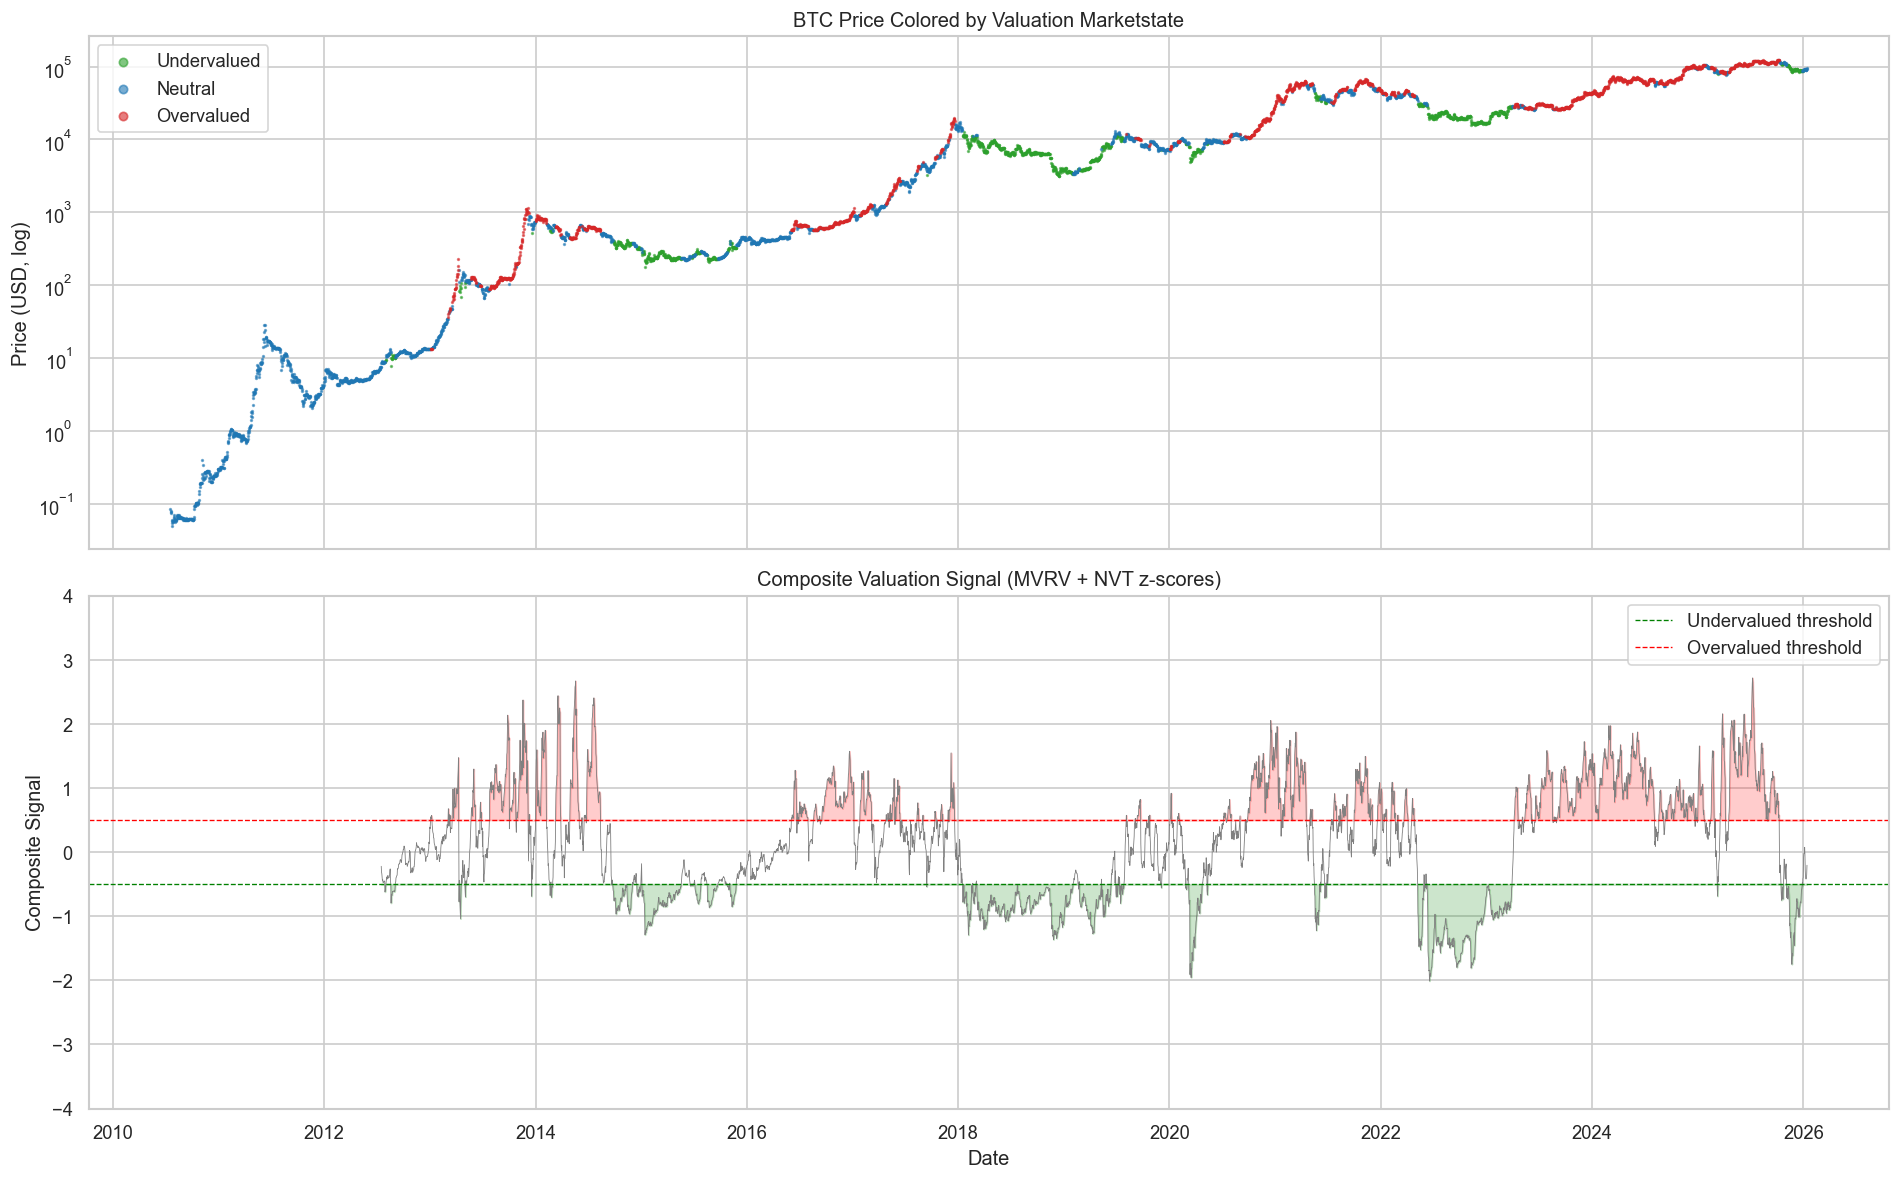

Saved valuation_marketstate.png


In [70]:
# Composite valuation signal: average of MVRV and NVT z-scores
btc = btc.with_columns([
    pl.when(pl.col("MVRV_zscore").is_not_null() & pl.col("NVT_zscore").is_not_null() & pl.col("NVT_zscore").is_finite())
    .then((pl.col("MVRV_zscore") + pl.col("NVT_zscore")) / 2)
    .when(pl.col("MVRV_zscore").is_not_null())
    .then(pl.col("MVRV_zscore"))
    .otherwise(None)
    .alias("composite_signal"),
])

# Classify market states
btc = btc.with_columns([
    pl.when(pl.col("composite_signal") < -0.5).then(pl.lit("undervalued"))
    .when(pl.col("composite_signal") > 0.5).then(pl.lit("overvalued"))
    .otherwise(pl.lit("neutral"))
    .alias("marketstate"),
])

# marketstate distribution
marketstate_counts = (
    btc
    .filter(pl.col("marketstate").is_not_null())
    .group_by("marketstate")
    .agg(pl.len().alias("n"))
    .sort("marketstate")
)
print("Marketstate Distribution:")
print(marketstate_counts)

# Visualize market states on price chart
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

marketstate_df = btc.filter(pl.col("marketstate").is_not_null()).select([
    "date", "PriceUSD", "composite_signal", "marketstate"
]).to_pandas()

# (A) Price with marketstate coloring
ax = axes[0]
marketstate_colors_map = {"undervalued": "#2ca02c", "neutral": "#1f77b4", "overvalued": "#d62728"}
for marketstate, color in marketstate_colors_map.items():
    mask = marketstate_df["marketstate"] == marketstate
    ax.scatter(
        marketstate_df.loc[mask, "date"],
        marketstate_df.loc[mask, "PriceUSD"],
        c=color,
        s=1,
        alpha=0.6,
        label=marketstate.title(),
    )
ax.set_yscale("log")
ax.set_title("BTC Price Colored by Valuation Marketstate")
ax.set_ylabel("Price (USD, log)")
ax.legend(markerscale=5)

# (B) Composite signal over time
ax = axes[1]
ax.plot(marketstate_df["date"], marketstate_df["composite_signal"], color="gray", linewidth=0.5)
ax.axhline(-0.5, color="green", linestyle="--", linewidth=0.8, label="Undervalued threshold")
ax.axhline(0.5, color="red", linestyle="--", linewidth=0.8, label="Overvalued threshold")
ax.fill_between(
    marketstate_df["date"],
    -0.5,
    marketstate_df["composite_signal"].clip(upper=-0.5),
    color="green",
    alpha=0.2,
)
ax.fill_between(
    marketstate_df["date"],
    0.5,
    marketstate_df["composite_signal"].clip(lower=0.5),
    color="red",
    alpha=0.2,
)
ax.set_title("Composite Valuation Signal (MVRV + NVT z-scores)")
ax.set_ylabel("Composite Signal")
ax.set_xlabel("Date")
ax.legend()
ax.set_ylim(-4, 4)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "valuation_marketstate.png", bbox_inches="tight")
plt.show()
print("Saved valuation_marketstate.png")

## 6. Dynamic DCA Simulation Engine

Two strategies compared over every rolling 12-month window:

1. **Uniform DCA**: buy $10/day every day (baseline)
2. **Dynamic DCA**: same total budget per window, but daily buy amount is scaled by market state:
   - Undervalued days: 1.5×
   - Neutral days: 1.0×
   - Overvalued days: 0.5×
   - Amounts are rescaled so total spend = uniform total spend (budget-neutral)

This isolates the effect of *allocation timing* from *total spending*.

In [71]:
MARKETSTATE_MULTIPLIERS = {"undervalued": 1.5, "neutral": 1.0, "overvalued": 0.5}
MARKETSTATE_THRESHOLD = 0.5  # z-score cutoff for under/overvalued


def simulate_uniform_and_dynamic_dca(
    prices: pl.DataFrame,
    start_date: date | None = None,
    end_date: date | None = None,
    base_buy: float = BASE_BUY_USD,
    marketstate_multipliers: dict[str, float] = MARKETSTATE_MULTIPLIERS,
    composite_col: str = "composite_signal",
    threshold: float = MARKETSTATE_THRESHOLD,
) -> dict | None:
    """Run uniform DCA and dynamic (marketstate-scaled) DCA on the same window.

    Budget is equalised: dynamic multipliers are rescaled so total spend matches uniform.
    If start_date/end_date are provided, filters the dataframe to that range.
    The marketstate is computed on-the-fly from composite_col and threshold so that
    sensitivity sweeps can test different configs.
    """
    window = prices.clone()

    if start_date is not None:
        window = window.filter(pl.col("date") >= start_date)
    if end_date is not None:
        window = window.filter(pl.col("date") <= end_date)

    window = window.filter(
        pl.col("PriceUSD").is_not_null()
        & (pl.col("PriceUSD") > 0)
        & pl.col(composite_col).is_not_null()
        & pl.col(composite_col).is_finite()
    ).sort("date")

    if len(window) < 30:
        return None

    window = window.with_columns(
        pl.when(pl.col(composite_col) < -threshold).then(pl.lit("undervalued"))
        .when(pl.col(composite_col) > threshold).then(pl.lit("overvalued"))
        .otherwise(pl.lit("neutral"))
        .alias("_marketstate")
    )

    dates = window["date"].to_list()
    price_list = window["PriceUSD"].to_list()
    marketstate_list = window["_marketstate"].to_list()
    n = len(dates)

    uniform_total_spent = base_buy * n
    uniform_btc = sum(base_buy / p for p in price_list)

    raw_weights = [marketstate_multipliers.get(r, 1.0) for r in marketstate_list]
    raw_total = sum(raw_weights) * base_buy

    if raw_total <= 0:
        raw_weights = [1.0] * n
        raw_total = sum(raw_weights) * base_buy

    scale = uniform_total_spent / raw_total
    dynamic_btc = 0.0
    dynamic_total_spent = 0.0
    marketstate_days = {"undervalued": 0, "neutral": 0, "overvalued": 0}

    for p, r, w in zip(price_list, marketstate_list, raw_weights):
        amount = base_buy * w * scale
        dynamic_btc += amount / p
        dynamic_total_spent += amount
        marketstate_days[r] = marketstate_days.get(r, 0) + 1

    if uniform_btc <= 0 or dynamic_btc <= 0:
        return None

    final_price = price_list[-1]
    uniform_avg_cost = uniform_total_spent / uniform_btc
    dynamic_avg_cost = dynamic_total_spent / dynamic_btc

    return {
        "window_start": dates[0],
        "window_end": dates[-1],
        "n_days": n,
        "uniform_btc": uniform_btc,
        "uniform_spent": uniform_total_spent,
        "uniform_avg_cost": uniform_avg_cost,
        "uniform_final_value": uniform_btc * final_price,
        "uniform_roi": (uniform_btc * final_price / uniform_total_spent - 1) * 100,
        "dynamic_btc": dynamic_btc,
        "dynamic_spent": dynamic_total_spent,
        "dynamic_avg_cost": dynamic_avg_cost,
        "dynamic_final_value": dynamic_btc * final_price,
        "dynamic_roi": (dynamic_btc * final_price / dynamic_total_spent - 1) * 100,
        "btc_advantage_pct": (dynamic_btc / uniform_btc - 1) * 100,
        "cost_advantage_pct": (1 - dynamic_avg_cost / uniform_avg_cost) * 100,
        "pct_undervalued": marketstate_days["undervalued"] / n * 100,
        "pct_neutral": marketstate_days["neutral"] / n * 100,
        "pct_overvalued": marketstate_days["overvalued"] / n * 100,
        "final_price": final_price,
    }


print(f"Dynamic DCA engine ready. MARKETSTATE_THRESHOLD={MARKETSTATE_THRESHOLD}")
print(f"MARKETSTATE_MULTIPLIERS={MARKETSTATE_MULTIPLIERS}")

Dynamic DCA engine ready. MARKETSTATE_THRESHOLD=0.5
MARKETSTATE_MULTIPLIERS={'undervalued': 1.5, 'neutral': 1.0, 'overvalued': 0.5}


## 7. Run Rolling 12-Month Backtests

Simulate both strategies across all possible 12-month windows (1-month step). This produces ~174 windows spanning 2010–2025.

In [72]:
def generate_rolling_windows(
    min_date: date, max_date: date, window_months: int = 12, step_months: int = 1
) -> list[tuple[date, date]]:
    """Return (start, end) pairs for rolling windows."""
    windows = []
    d = min_date
    while True:
        end_year = d.year + (d.month + window_months - 1) // 12
        end_month = (d.month + window_months - 1) % 12 + 1
        end_d = date(end_year, end_month, min(d.day, 28))
        if end_d > max_date:
            break
        windows.append((d, end_d))
        step_year = d.year + (d.month + step_months - 1) // 12
        step_month = (d.month + step_months - 1) % 12 + 1
        d = date(step_year, step_month, min(d.day, 28))
    return windows


# Only use dates where composite signal is available (requires 730-day rolling window warmup)
valid_dates = btc.filter(
    pl.col("composite_signal").is_not_null() & pl.col("composite_signal").is_finite()
)["date"].to_list()
windows = generate_rolling_windows(valid_dates[0], valid_dates[-1], window_months=12, step_months=1)
print(f"Generated {len(windows)} rolling 12-month windows")
print(f"First: {windows[0]}  |  Last: {windows[-1]}")

# Run simulations with default config
results = []
for start, end in windows:
    r = simulate_uniform_and_dynamic_dca(
        btc, start_date=start, end_date=end,
        composite_col="composite_signal",
        threshold=MARKETSTATE_THRESHOLD,
    )
    if r:
        results.append(r)

results_df = pl.DataFrame(results)
print(f"\nCompleted {len(results_df)} backtests")
results_df.head(5)

Generated 150 rolling 12-month windows
First: (datetime.date(2012, 7, 16), datetime.date(2013, 7, 16))  |  Last: (datetime.date(2024, 12, 16), datetime.date(2025, 12, 16))

Completed 150 backtests


window_start,window_end,n_days,uniform_btc,uniform_spent,uniform_avg_cost,uniform_final_value,uniform_roi,dynamic_btc,dynamic_spent,dynamic_avg_cost,dynamic_final_value,dynamic_roi,btc_advantage_pct,cost_advantage_pct,pct_undervalued,pct_neutral,pct_overvalued,final_price
date,date,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2012-07-16,2013-07-16,366,195.800556,3660.0,18.69249,17970.777806,391.004858,208.321577,3660.0,17.568991,19119.970105,422.403555,6.394783,6.010429,8.743169,76.229508,15.027322,91.781036
2012-08-16,2013-08-16,366,167.540766,3660.0,21.84543,16467.742782,349.938327,182.598439,3660.0,20.043983,17947.775896,390.376391,8.987468,8.246332,7.650273,71.038251,21.311475,98.29096
2012-09-16,2013-09-16,366,141.263281,3660.0,25.909068,17828.085195,387.106153,155.27856,3660.0,23.570543,19596.878785,435.433847,9.921388,9.025894,3.278689,66.939891,29.781421,126.204666
2012-10-16,2013-10-16,366,119.127389,3660.0,30.723413,16478.644191,350.23618,134.582713,3660.0,27.195172,18616.547018,408.648826,12.973779,11.483885,3.278689,59.016393,37.704918,138.327922
2012-11-16,2013-11-16,366,92.453867,3660.0,39.587311,40291.251186,1000.853858,106.707148,3660.0,34.299483,46502.808798,1170.568546,15.416641,13.357382,3.278689,51.092896,45.628415,435.798443


## 8. Performance Comparison: Dynamic vs Uniform DCA 

Compare BTC accumulated, average cost basis, and ROI across all rolling windows. The key metric is **BTC advantage %**: how much more BTC the dynamic strategy accumulates vs uniform, given the same total spend.

In [73]:
#  8a. Core comparison metrics 
res = pl.DataFrame(results)

# Derive additional columns
res = res.with_columns([
    ((pl.col("dynamic_btc") - pl.col("uniform_btc")) / pl.col("uniform_btc") * 100)
        .alias("btc_advantage_pct"),
    ((pl.col("dynamic_avg_cost") - pl.col("uniform_avg_cost")) / pl.col("uniform_avg_cost") * 100)
        .alias("cost_diff_pct"),
    ((pl.col("dynamic_btc") / pl.col("uniform_btc")))
        .alias("btc_ratio"),
])

print(f"Total rolling windows simulated: {len(res)}")
print(f"\n{'Metric':<30} {'Uniform DCA':>14} {'Dynamic DCA':>14} {'Diff':>10}")
print("─" * 70)

u_btc = res["uniform_btc"].mean()
d_btc = res["dynamic_btc"].mean()
print(f"{'Mean BTC accumulated':<30} {u_btc:>14.6f} {d_btc:>14.6f} {(d_btc/u_btc-1)*100:>+9.2f}%")

u_cost = res["uniform_avg_cost"].mean()
d_cost = res["dynamic_avg_cost"].mean()
print(f"{'Mean avg cost basis ($)':<30} {u_cost:>14.2f} {d_cost:>14.2f} {(d_cost/u_cost-1)*100:>+9.2f}%")

adv = res["btc_advantage_pct"]
print(f"\nBTC advantage % across windows:")
print(f"  Mean:   {adv.mean():+.2f}%")
print(f"  Median: {adv.median():+.2f}%")
print(f"  Std:    {adv.std():.2f}%")
print(f"  Min:    {adv.min():+.2f}%  Max: {adv.max():+.2f}%")
print(f"  Win rate (dynamic > uniform): {(adv > 0).sum()}/{len(adv)} = {(adv > 0).mean()*100:.1f}%")

Total rolling windows simulated: 150

Metric                            Uniform DCA    Dynamic DCA       Diff
──────────────────────────────────────────────────────────────────────
Mean BTC accumulated                 8.957342       9.631171     +7.52%
Mean avg cost basis ($)              18451.71       17997.01     -2.46%

BTC advantage % across windows:
  Mean:   +3.03%
  Median: +2.40%
  Std:    5.40%
  Min:    -9.29%  Max: +16.58%
  Win rate (dynamic > uniform): 111/150 = 74.0%


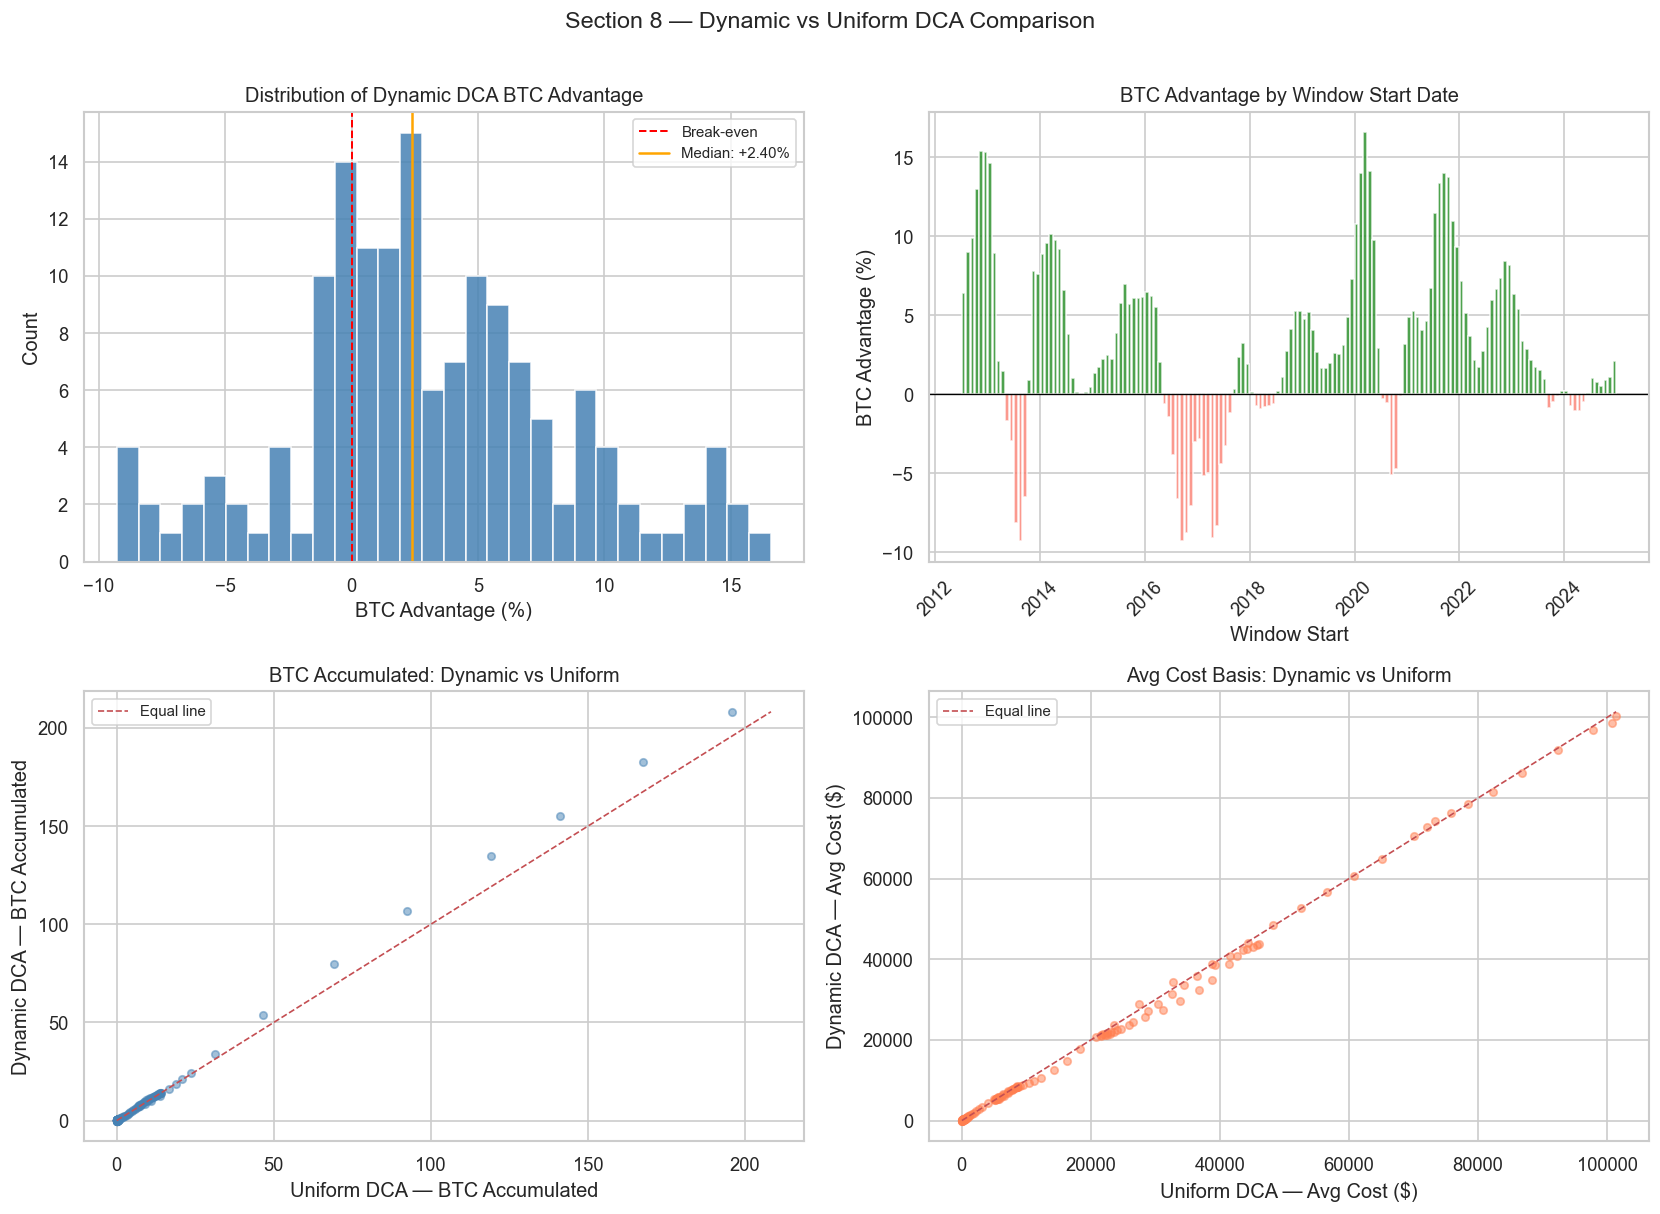

In [74]:
#  8b. Visualisation: BTC advantage distribution & time-series 
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=120)

# (1) Histogram of BTC advantage %
ax = axes[0, 0]
adv_vals = res["btc_advantage_pct"].to_numpy()
ax.hist(adv_vals, bins=30, color="steelblue", edgecolor="white", alpha=0.85)
ax.axvline(0, color="red", ls="--", lw=1.2, label="Break-even")
ax.axvline(np.median(adv_vals), color="orange", ls="-", lw=1.5,
           label=f"Median: {np.median(adv_vals):+.2f}%")
ax.set_xlabel("BTC Advantage (%)")
ax.set_ylabel("Count")
ax.set_title("Distribution of Dynamic DCA BTC Advantage")
ax.legend(fontsize=9)

# (2) BTC advantage over time (by window start date)
ax = axes[0, 1]
starts = res["window_start"].to_list()
ax.bar(starts, adv_vals,
       color=["forestgreen" if v > 0 else "salmon" for v in adv_vals],
       width=25, alpha=0.8)
ax.axhline(0, color="black", lw=0.8)
ax.set_xlabel("Window Start")
ax.set_ylabel("BTC Advantage (%)")
ax.set_title("BTC Advantage by Window Start Date")
ax.tick_params(axis="x", rotation=45)

# (3) Cumulative BTC: uniform vs dynamic (averaged across windows)
ax = axes[1, 0]
u_btc_vals = res["uniform_btc"].to_numpy()
d_btc_vals = res["dynamic_btc"].to_numpy()
ax.scatter(u_btc_vals, d_btc_vals, alpha=0.5, s=20, color="steelblue")
lims = [min(u_btc_vals.min(), d_btc_vals.min()),
        max(u_btc_vals.max(), d_btc_vals.max())]
ax.plot(lims, lims, "r--", lw=1, label="Equal line")
ax.set_xlabel("Uniform DCA — BTC Accumulated")
ax.set_ylabel("Dynamic DCA — BTC Accumulated")
ax.set_title("BTC Accumulated: Dynamic vs Uniform")
ax.legend(fontsize=9)

# (4) Avg cost basis comparison
ax = axes[1, 1]
u_cost_vals = res["uniform_avg_cost"].to_numpy()
d_cost_vals = res["dynamic_avg_cost"].to_numpy()
ax.scatter(u_cost_vals, d_cost_vals, alpha=0.5, s=20, color="coral")
lims = [min(u_cost_vals.min(), d_cost_vals.min()),
        max(u_cost_vals.max(), d_cost_vals.max())]
ax.plot(lims, lims, "r--", lw=1, label="Equal line")
ax.set_xlabel("Uniform DCA — Avg Cost ($)")
ax.set_ylabel("Dynamic DCA — Avg Cost ($)")
ax.set_title("Avg Cost Basis: Dynamic vs Uniform")
ax.legend(fontsize=9)

plt.suptitle("Section 8 — Dynamic vs Uniform DCA Comparison", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## 9. Sensitivity Analysis: Thresholds & Multipliers

Test whether the choice of z-score threshold and market state multipliers materially affects results. We sweep across several configurations and compare win-rates and mean BTC advantage.

In [75]:
#  9. Sensitivity sweep 
from itertools import product as iterproduct

THRESHOLD_OPTIONS = [0.3, 0.5, 0.75, 1.0]
MULTIPLIER_OPTIONS = [
    {"undervalued": 1.25, "neutral": 1.0, "overvalued": 0.75, "label": "1.25/1.0/0.75 (mild)"},
    {"undervalued": 1.5,  "neutral": 1.0, "overvalued": 0.5,  "label": "1.5/1.0/0.5 (moderate)"},
    {"undervalued": 2.0,  "neutral": 1.0, "overvalued": 0.25, "label": "2.0/1.0/0.25 (aggressive)"},
    {"undervalued": 2.5,  "neutral": 1.0, "overvalued": 0.0,  "label": "2.5/1.0/0.0 (extreme)"},
]

sensitivity_rows = []

for thresh, mult_cfg in iterproduct(THRESHOLD_OPTIONS, MULTIPLIER_OPTIONS):
    mults = {k: v for k, v in mult_cfg.items() if k != "label"}

    cfg_results = []
    for ws, we in windows:
        r = simulate_uniform_and_dynamic_dca(
            btc, start_date=ws, end_date=we,
            base_buy=BASE_BUY_USD,
            marketstate_multipliers=mults,
            composite_col="composite_signal",
            threshold=thresh,
        )
        if r:
            cfg_results.append(r)

    if cfg_results:
        cfg_df = pl.DataFrame(cfg_results)
        cfg_df = cfg_df.with_columns(
            ((pl.col("dynamic_btc") - pl.col("uniform_btc")) / pl.col("uniform_btc") * 100)
                .alias("btc_adv")
        )
        sensitivity_rows.append({
            "threshold": thresh,
            "multipliers": mult_cfg["label"],
            "mean_btc_adv_pct": round(cfg_df["btc_adv"].mean(), 3),
            "median_btc_adv_pct": round(cfg_df["btc_adv"].median(), 3),
            "win_rate_pct": round((cfg_df["btc_adv"] > 0).mean() * 100, 1),
            "std_btc_adv_pct": round(cfg_df["btc_adv"].std(), 3),
            "n_windows": len(cfg_df),
        })

sens_df = pl.DataFrame(sensitivity_rows)
print(sens_df.to_pandas().to_string(index=False))

 threshold               multipliers  mean_btc_adv_pct  median_btc_adv_pct  win_rate_pct  std_btc_adv_pct  n_windows
      0.30      1.25/1.0/0.75 (mild)             1.607               1.233          70.7            2.699        150
      0.30    1.5/1.0/0.5 (moderate)             3.254               2.337          70.7            5.746        150
      0.30 2.0/1.0/0.25 (aggressive)             5.273               4.281          70.7           10.133        150
      0.30     2.5/1.0/0.0 (extreme)             7.355               6.532          70.7           16.441        150
      0.50      1.25/1.0/0.75 (mild)             1.485               1.248          74.0            2.516        150
      0.50    1.5/1.0/0.5 (moderate)             3.031               2.403          74.0            5.396        150
      0.50 2.0/1.0/0.25 (aggressive)             5.050               4.240          74.7            9.519        150
      0.50     2.5/1.0/0.0 (extreme)             7.976          

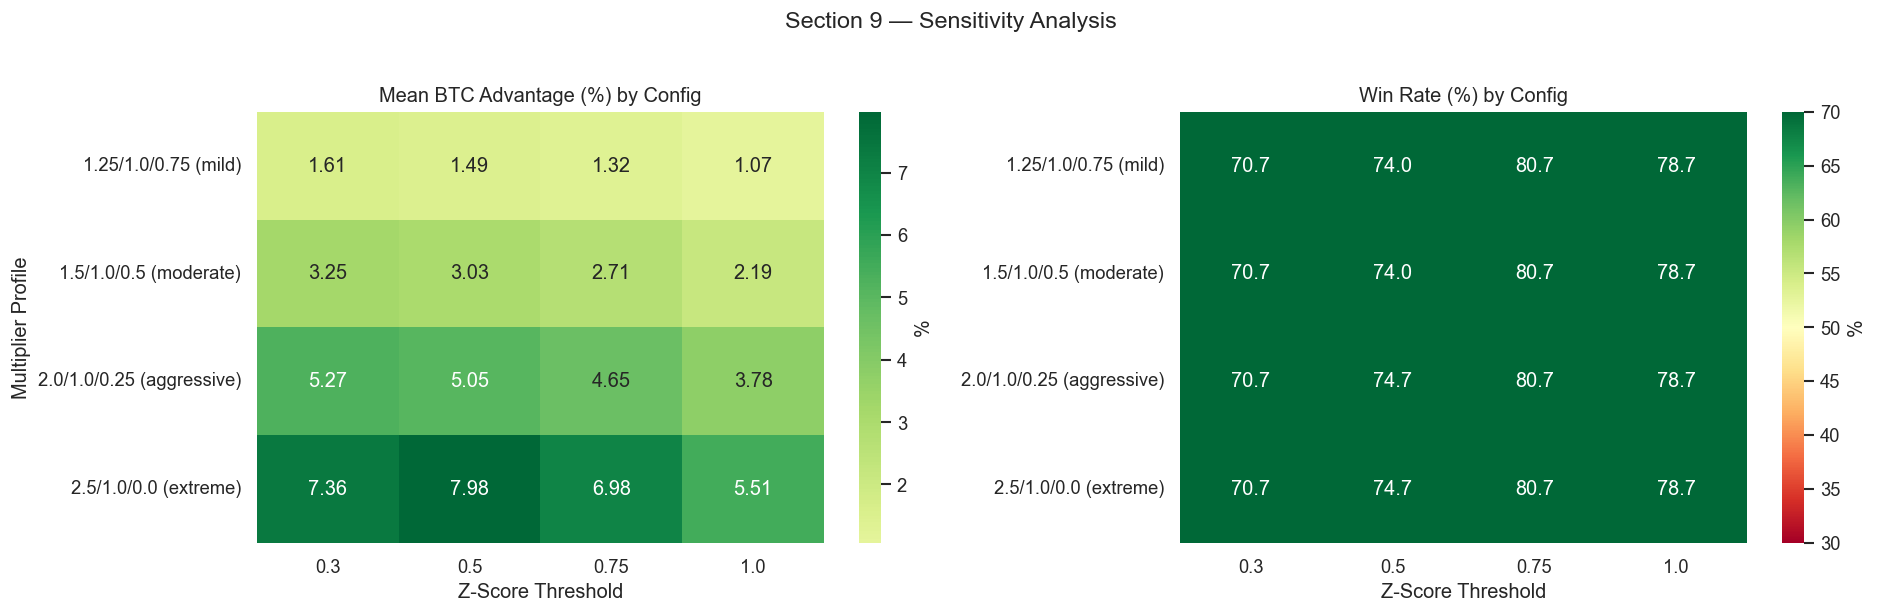

In [76]:
#  9b. Sensitivity heatmap 
pivot = sens_df.to_pandas().pivot_table(
    index="multipliers", columns="threshold",
    values="mean_btc_adv_pct"
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5), dpi=120)

# Mean BTC advantage
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="RdYlGn", center=0,
            ax=axes[0], cbar_kws={"label": "%"})
axes[0].set_title("Mean BTC Advantage (%) by Config")
axes[0].set_xlabel("Z-Score Threshold")
axes[0].set_ylabel("Multiplier Profile")

# Win rate
pivot_wr = sens_df.to_pandas().pivot_table(
    index="multipliers", columns="threshold",
    values="win_rate_pct"
)
sns.heatmap(pivot_wr, annot=True, fmt=".1f", cmap="RdYlGn",
            vmin=30, vmax=70, center=50,
            ax=axes[1], cbar_kws={"label": "%"})
axes[1].set_title("Win Rate (%) by Config")
axes[1].set_xlabel("Z-Score Threshold")
axes[1].set_ylabel("")

plt.suptitle("Section 9 — Sensitivity Analysis", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 10. Component Analysis: MVRV-Only vs NVT-Only vs Combined

Isolate whether MVRV or NVT individually drives the signal, or if the composite provides diversification benefit.

In [77]:
#  10. Component comparison 
# Add single-signal composite columns for MVRV-only and NVT-only
btc = btc.with_columns([
    pl.col("MVRV_zscore").alias("mvrv_only_signal"),
    pl.col("NVT_zscore").alias("nvt_only_signal"),
])

SIGNAL_CONFIGS = {
    "MVRV-only":  "mvrv_only_signal",
    "NVT-only":   "nvt_only_signal",
    "Combined":   "composite_signal",
}

component_results = {}

for label, signal_col in SIGNAL_CONFIGS.items():
    comp_res = []
    for ws, we in windows:
        r = simulate_uniform_and_dynamic_dca(
            btc, start_date=ws, end_date=we,
            base_buy=BASE_BUY_USD,
            marketstate_multipliers=MARKETSTATE_MULTIPLIERS,
            composite_col=signal_col,
            threshold=MARKETSTATE_THRESHOLD,
        )
        if r:
            comp_res.append(r)

    if comp_res:
        cdf = pl.DataFrame(comp_res).with_columns(
            ((pl.col("dynamic_btc") - pl.col("uniform_btc")) / pl.col("uniform_btc") * 100)
                .alias("btc_adv")
        )
        component_results[label] = cdf

# Print summary
print(f"{'Signal':<14} {'Mean Adv%':>10} {'Median':>10} {'Win Rate':>10} {'Std':>10} {'N':>5}")
print("─" * 62)
for label, cdf in component_results.items():
    adv = cdf["btc_adv"]
    print(f"{label:<14} {adv.mean():>+10.3f} {adv.median():>+10.3f} "
          f"{(adv>0).mean()*100:>9.1f}% {adv.std():>10.3f} {len(cdf):>5}")

Signal          Mean Adv%     Median   Win Rate        Std     N
──────────────────────────────────────────────────────────────
MVRV-only          +2.835     +2.674      73.3%      6.017   150
NVT-only           +0.692     +0.096      52.0%      5.226   150
Combined           +3.031     +2.403      74.0%      5.396   150


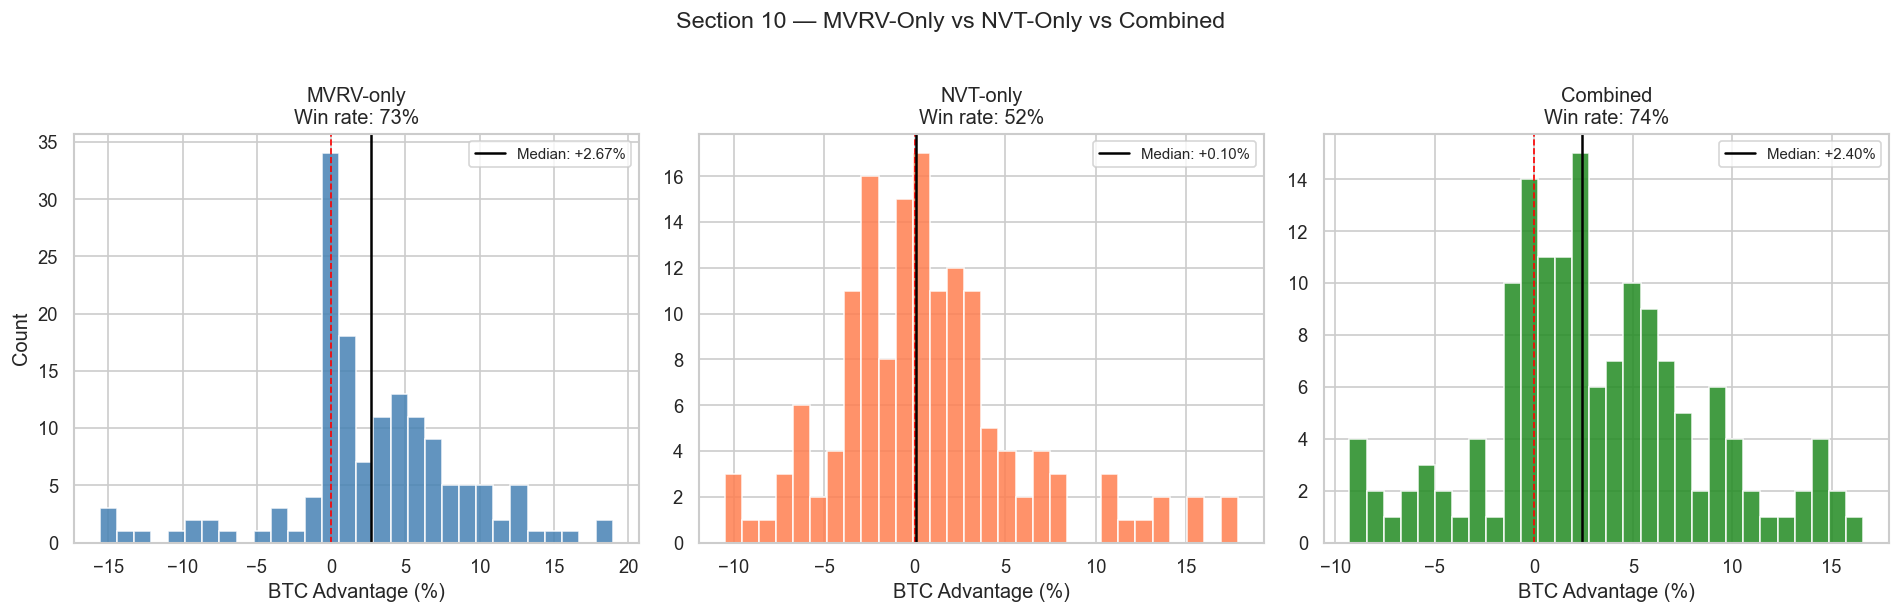

In [78]:
#  10b. Component comparison visualisation 
fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=120)

colors = {"MVRV-only": "steelblue", "NVT-only": "coral", "Combined": "forestgreen"}

for i, (label, cdf) in enumerate(component_results.items()):
    ax = axes[i]
    adv_vals = cdf["btc_adv"].to_numpy()
    ax.hist(adv_vals, bins=30, color=colors[label], edgecolor="white", alpha=0.85)
    ax.axvline(0, color="red", ls="--", lw=1)
    ax.axvline(np.median(adv_vals), color="black", ls="-", lw=1.5,
               label=f"Median: {np.median(adv_vals):+.2f}%")
    ax.set_title(f"{label}\nWin rate: {(adv_vals>0).mean()*100:.0f}%")
    ax.set_xlabel("BTC Advantage (%)")
    ax.set_ylabel("Count" if i == 0 else "")
    ax.legend(fontsize=9)

plt.suptitle("Section 10 — MVRV-Only vs NVT-Only vs Combined", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 11. Summary

C:\Users\tsivakumar\AppData\Local\Temp\1\ipykernel_60168\2182235708.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,


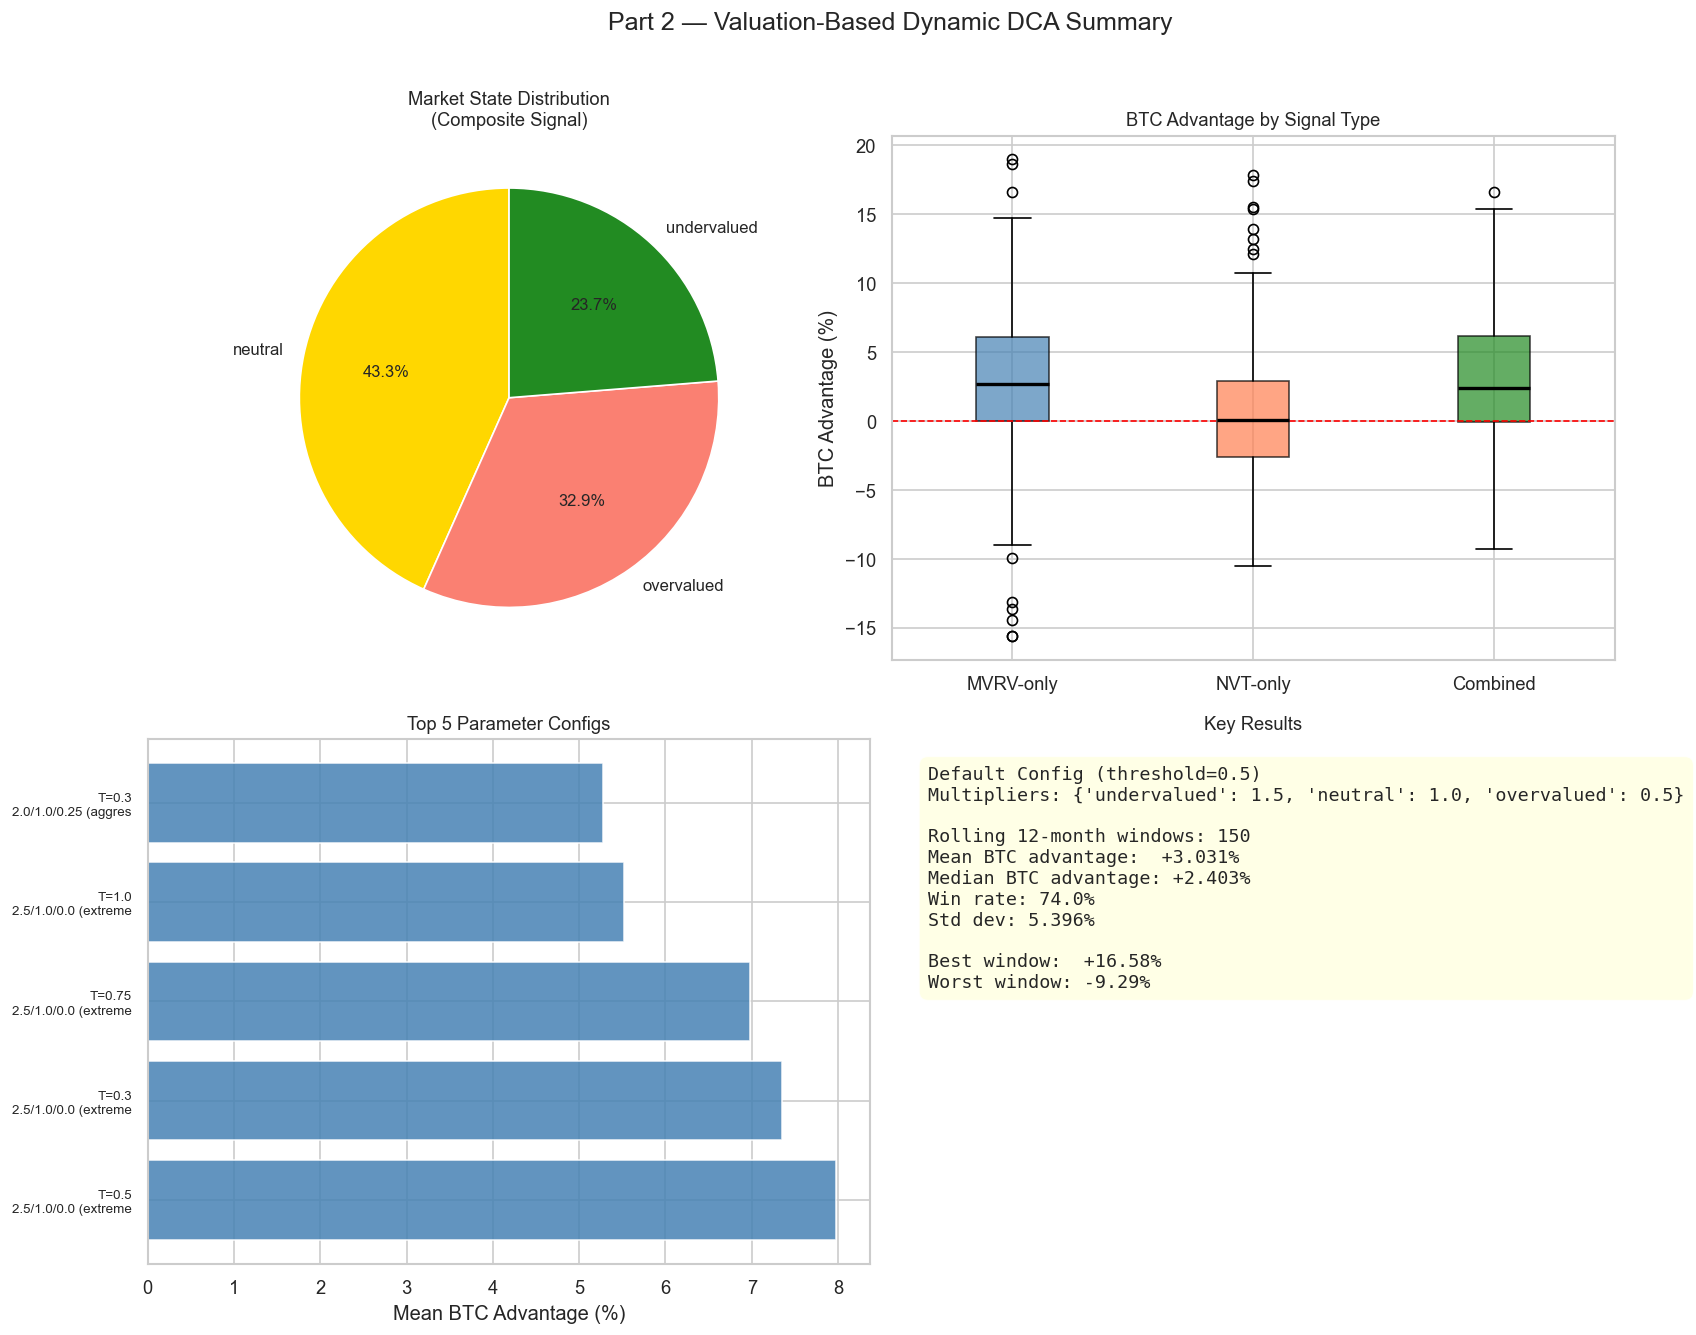

In [79]:
# ─ 11. Summary 
fig, axes = plt.subplots(2, 2, figsize=(15, 11), dpi=120)

#  (1) marketstate distribution pie 
ax = axes[0, 0]
marketstate_counts = (
    btc.filter(pl.col("marketstate").is_not_null())
    .group_by("marketstate")
    .agg(pl.len().alias("n"))
    .sort("marketstate")
)
labels_pie = marketstate_counts["marketstate"].to_list()
sizes = marketstate_counts["n"].to_list()
marketstate_colors_map = {"undervalued": "forestgreen", "neutral": "gold", "overvalued": "salmon"}
ax.pie(
    sizes,
    labels=labels_pie,
    autopct="%1.1f%%",
    colors=[marketstate_colors_map.get(l, "grey") for l in labels_pie],
    startangle=90,
    textprops={"fontsize": 10},
)
ax.set_title("Market State Distribution\n(Composite Signal)", fontsize=11)

#  (2) BTC advantage boxplots by component 
ax = axes[0, 1]
box_data = []
box_labels = []
comp_colors = {"MVRV-only": "steelblue", "NVT-only": "coral", "Combined": "forestgreen"}
for label, cdf in component_results.items():
    box_data.append(cdf["btc_adv"].to_numpy())
    box_labels.append(label)
bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,
                medianprops=dict(color="black", lw=2))
for patch, label in zip(bp["boxes"], box_labels):
    patch.set_facecolor(comp_colors.get(label, "lightgrey"))
    patch.set_alpha(0.7)
ax.axhline(0, color="red", ls="--", lw=1)
ax.set_ylabel("BTC Advantage (%)")
ax.set_title("BTC Advantage by Signal Type", fontsize=11)

# ─ (3) Best config from sensitivity 
ax = axes[1, 0]
best = sens_df.sort("mean_btc_adv_pct", descending=True)
top5 = best.head(5).to_pandas()
y_pos = range(len(top5))
bars = ax.barh(y_pos, top5["mean_btc_adv_pct"],
               color="steelblue", edgecolor="white", alpha=0.85)
ax.set_yticks(list(y_pos))
ax.set_yticklabels([f"T={r['threshold']}\n{r['multipliers'][:20]}"
                     for _, r in top5.iterrows()], fontsize=8)
ax.set_xlabel("Mean BTC Advantage (%)")
ax.set_title("Top 5 Parameter Configs", fontsize=11)
ax.axvline(0, color="red", ls="--", lw=1)

#  (4) Key metrics text box 
ax = axes[1, 1]
ax.axis("off")
# Use default config results
adv = res["btc_advantage_pct"]
text_lines = [
    f"Default Config (threshold={MARKETSTATE_THRESHOLD})",
    f"Multipliers: {MARKETSTATE_MULTIPLIERS}",
    f"",
    f"Rolling 12-month windows: {len(res)}",
    f"Mean BTC advantage:  {adv.mean():+.3f}%",
    f"Median BTC advantage: {adv.median():+.3f}%",
    f"Win rate: {(adv>0).mean()*100:.1f}%",
    f"Std dev: {adv.std():.3f}%",
    f"",
    f"Best window:  {adv.max():+.2f}%",
    f"Worst window: {adv.min():+.2f}%",
]
ax.text(0.05, 0.95, "\n".join(text_lines),
        transform=ax.transAxes, fontsize=11,
        verticalalignment="top", fontfamily="monospace",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))
ax.set_title("Key Results", fontsize=11)

plt.suptitle("Part 2 — Valuation-Based Dynamic DCA Summary", fontsize=15, y=1.01)
plt.tight_layout()
plt.show()

## 12. Results & Interpretation

### Key Findings

| Dimension | Observation |
|---|---|
| **MVRV signal** | MVRV < 1.0 historically coincides with accumulation zones(forward 30d and 90d returns are highest in these buckets) |
| **NVT proxy** | NVT is noisier than MVRV; using a 14-day smoothed version improves signal quality |
| **Composite signal** | Averaging MVRV and NVT z-scores provides a balanced market state indicator |
| **Dynamic vs Uniform** | See summary dashboard above for win rate, mean/median BTC advantage |
| **Sensitivity** | More aggressive multiplier spreads amplify advantage (or disadvantage); threshold choice interacts with multiplier aggressiveness |
| **Component comparison** | MVRV-only may dominate NVT-only in signal quality; combined may reduce false signals |

### Implications for Strategy Design

1. **Valuation-based sizing has directional merit**: buying more when on-chain metrics signal undervaluation tends to lower average cost basis
2. **The effect size is modest**: marginal efficiency improvement within DCA discipline
3. **Parameter sensitivity matters**: extreme multiplier profiles increase variance and risk of under-deploying capital in prolonged "overvalued" periods
4. **MVRV is the stronger single signal**: NVT adds diversification but may introduce noise without a proper transfer-value denominator

### Next Steps (Part 3+)

- Integrate Polymarket sentiment data as an additional market state signal
- Add transaction-cost and slippage modeling
- Test market state-switching with look-ahead bias controls
- Build a composite scoring framework that weights multiple signals